## Выбор трека: Мультимодальные данные

### Описание датасета
В качестве исходного датасета я выбрала **CheXpert** (https://www.kaggle.com/datasets/mimsadiislam/chexpert?select=CheXpert-v1.0-small), так как он уже размечен врачами (при всем желании, рентгены я размечаю плохо).

Исходный датасет состоит из изображений медицинских рентгеновских снимков и соответствующих им описаний в форме CSV-файлов. Вот описание структуры исходного датасета:

- **Структура директории**: 
Есть две основные директории: train и valid, представляющие обучающий и валидационный наборы данных соответственно.
<p>

- **Данные о пациентах**:
Внутри каждой из директорий (train и valid) находятся поддиректории с идентификаторами пациентов (например, patient00001).
<p>

- **Данные об исследованиях**:
В каждой поддиректории пациента есть дополнительные поддиректории с именами study1, study2 и так далее, представляющие различные исследования, проведенные у каждого пациента.
<p>

- **Изображения**:
В каждой поддиректории study содержатся изображения, представленные в формате JPEG. Названия файлов построены в соответствии с принципом: view{номер пациента}_{тип фото}.jpg, где {тип фото} может быть frontal (фронтальное изображение) или lateral (латеральное изображение). Пример: view1_frontal.jpg.
<p>

- **CSV-файлы с описаниями**:
В корневой директории CheXpert-v1.0-small находятся CSV-файлы train.csv и valid.csv. Эти файлы содержат описания для каждого изображения, включая путь к изображению, пол, возраст и информацию о различных медицинских признаках (например, наличие заболеваний, характеристики снимка).

### Принцип связки мультимодельных данных
CSV-файлы содержат информацию о путях к изображениям и соответствующие описания, таким образом, получается связь между текстовыми данными и соответствующими изображениями. Принцип связки следующий:
    
- CSV-файлы (train.csv и valid.csv) содержат столбец "Path", в котором указан путь к соответствующему изображению. Этот путь действует как уникальный идентификатор изображения в датасете.
<p>
    
- Сами изображения находятся в папках train и valid, организованных по структуре "пациент -> исследование -> изображение". Изображения именуются согласно принципу "view{номер пациента}_{тип фото}".

    
**Связка данных осуществляется путем соотнесения пути из CSV-файлов с реальными изображениями.**

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
import cv2

from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [60]:
train_df = pd.read_csv('CheXpert-v1.0-small/train.csv')
valid_df = pd.read_csv('CheXpert-v1.0-small/valid.csv')

### Разметка
-  формируются строки признаков (feature_string) и диагнозов(diagnosis), которые отражают наличие или отсутствие определенных медицинских патологий на рентгеновских снимках и поставленные диагнозы соответственно

In [61]:
train_df['train_valid'] = 0
valid_df['train_valid'] = 1

train_df[['patient', 'study']] = train_df['Path'].str.split('/', expand=True)[[2, 3]]
valid_df[['patient', 'study']] = valid_df['Path'].str.split('/', expand=True)[[2, 3]]

df = pd.concat([train_df, valid_df])

In [62]:
diagnosis_features = ['Atelectasis', 'Edema', 'Pneumonia'] # определяемые диагнозы
features = ['Enlarged Cardiomediastinum', 'Lung Opacity', 
            'Cardiomegaly', 'Consolidation', 'Pneumothorax', 
            'Pleural Effusion', 'Fracture'] # патологии и симптомы

In [63]:
def feature_string(row):
    feature_list = []
    for feature in diagnosis_features:
        if row[feature] in [-1,1]:
            feature_list.append(feature)
            
    for feature in features:
        if row[feature] == 1:
            feature_list.append(feature)
            
    return ';'.join(feature_list)

In [64]:
df['feature_string'] = df.apply(feature_string,axis = 1).fillna('')
df['feature_string'] = df['feature_string'] .apply(lambda x:x.split(";"))
df['diagnosis'] = df.apply(lambda row: [feature for feature in diagnosis_features if row[feature] == 1], axis=1)

In [65]:
df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,train_valid,patient,study,feature_string,diagnosis
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,1.0,0,patient00001,study1,[],[]
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,NaN,-1.0,NaN,1.0,NaN,0,patient00002,study2,"[Atelectasis, Edema, Lung Opacity, Fracture]",[]
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,1.0,NaN,0,patient00002,study1,"[Lung Opacity, Fracture]",[]
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,1.0,NaN,0,patient00002,study1,"[Lung Opacity, Fracture]",[]
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0,patient00003,study1,[Edema],[Edema]


### Предварительная обработка данных

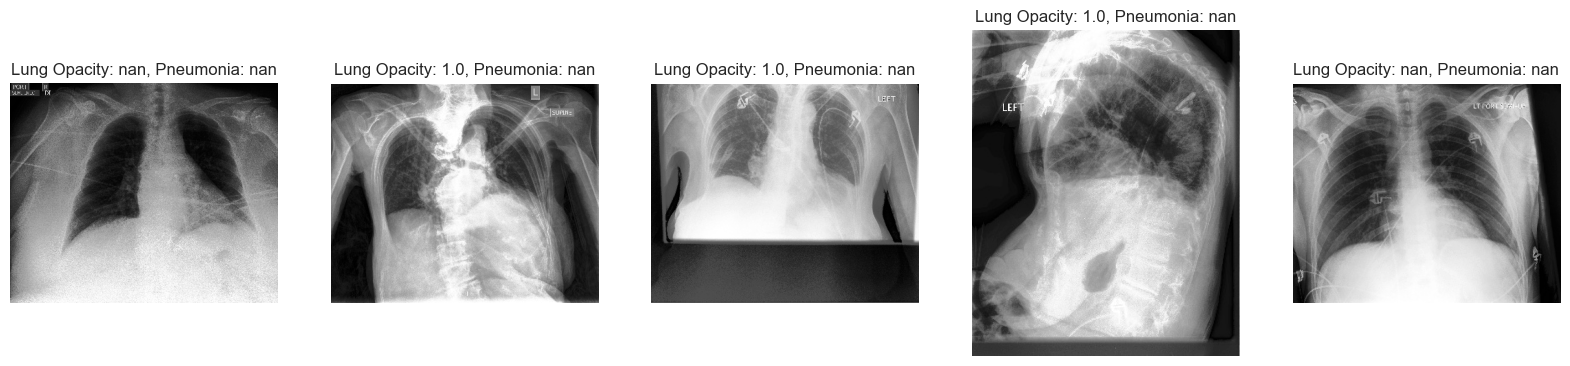

In [66]:
sample_df = df.head(5)

fig, axs = plt.subplots(1, len(sample_df), figsize=(20, 10))

for i, (index, row) in enumerate(sample_df.iterrows()):
    img_path = row['Path']
    img = Image.open(img_path).convert('L')
    axs[i].imshow(img, cmap='gray', vmin=0, vmax=255)
    feature_names = ['Lung Opacity', 'Pneumonia']
    feature_values = row[feature_names].astype(str).values
    labels = [f"{name}: {value}" for name, value in zip(feature_names, feature_values)]
    axs[i].set_title(', '.join(labels))
    axs[i].axis('off')

plt.show()

- Для обработки изображений в целях улучшения четкости, фильтрации шума и коррекции экспозиции были выбраны unsharp masking, билатеральная фильтрация и адаптивная коррекция экспозиции

In [67]:
def process_and_save_image(input_path, output_folder):
    
        # Проверка наличия файла изображения
    if not os.path.isfile(input_path):
        print(f"Файл изображения не найден: {input_path}")
        return

    image = cv2.imread(input_path)

    # Проверка успешности чтения изображения
    if image is None:
        print(f"Не удалось прочитать изображение: {input_path}")
        return
    
    # Применение Unsharp Masking
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    sharpened = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)

    # Применение билатеральной фильтрации
    bilateral_filtered = cv2.bilateralFilter(sharpened, 9, 75, 75)

    # Применение адаптивной коррекции экспозиции
    lab = cv2.cvtColor(bilateral_filtered, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # Сохранение обработанного изображения
    output_path = os.path.join(output_folder, os.path.basename(input_path))
    cv2.imwrite(output_path, final)

In [68]:
sample_df = train_df.head(10)
tqdm_pbar = tqdm(total=len(sample_df), desc='Обработка изображений (sample)')

output_folder = 'edited_img/sample'
os.makedirs(output_folder, exist_ok=True)

for index, row in sample_df.iterrows():
    image_path = row['Path']
    process_and_save_image(image_path, output_folder)
    tqdm_pbar.update(1)

tqdm_pbar.close()

Обработка изображений (sample): 100%|██████████████████████████████████████████████████| 10/10 [00:00<00:00, 71.94it/s]


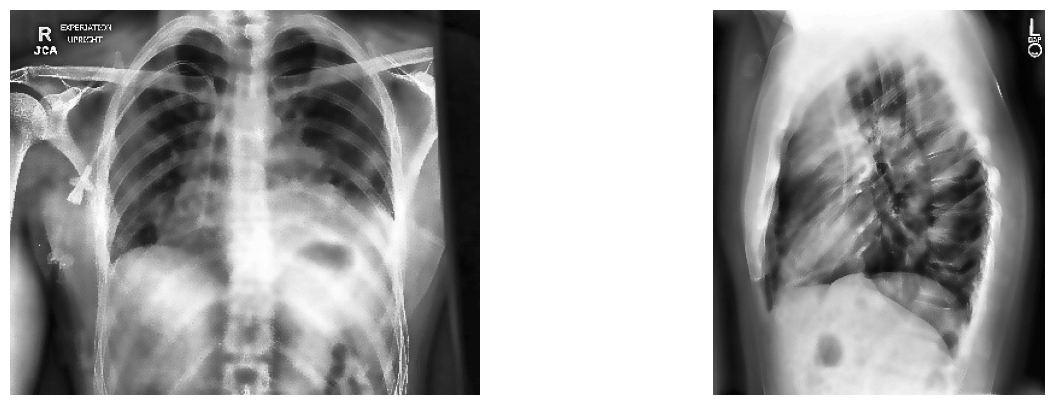

In [69]:
image_files = os.listdir(output_folder)[:2]

fig, axs = plt.subplots(1, len(image_files), figsize=(15, 5))

for i, image_file in enumerate(image_files):
    image_path = os.path.join(output_folder, image_file)
    img = Image.open(image_path)
    axs[i].imshow(img)
    axs[i].axis('off')

plt.show()

Обработанные изображения в результате применения методов unsharp masking, билатеральной фильтрации и адаптивной коррекции экспозиции, к сожалению, потеряли некоторые детали и не соответствуют ожиданиям. После анализа результата решено, что использование оригинальных фотографий для обучения модели будет более эффективным в данном случае.

In [70]:
# Подсчет уникальных значений и пропусков
unique_values = []
missing_values = []

for column in df.columns:
    if column == 'diagnosis':
        empty_count = df[column].apply(lambda x: isinstance(x, list) and len(x) == 0).sum()
        unique_values.append(len(set([item for sublist in df[column] for item in sublist])))
        missing_values.append(empty_count)
    elif column == 'feature_string':
        empty_count = df[column].apply(lambda x: isinstance(x, list) and len(x) == 0).sum()
        unique_values.append(len(set([item for sublist in df[column].explode() for item in sublist])))
        missing_values.append(empty_count)
    else:
        unique_values.append(df[column].nunique())
        missing_values.append(df[column].isnull().sum())

result_df = pd.DataFrame({'Unique Values': unique_values, 'Missing Values': missing_values}, index=df.columns)
result_df

,Unique Values,Missing Values
Path,223648,0
Sex,3,0
Age,74,0
Frontal/Lateral,2,0
AP/PA,4,32419
No Finding,2,201033
Enlarged Cardiomediastinum,3,178575
Cardiomegaly,3,177211
Lung Opacity,3,105636
Lung Lesion,3,211470


In [71]:
# Вывод самих уникальных значений (если их меньше 5)
exclude_columns = ['feature_string', 'diagnosis'] 
for column in df.columns:
    if column not in exclude_columns:
        unique_vals = df[column].unique()
        if len(unique_vals) <= 5:
            print(f'\nUnique values for column "{column}": {unique_vals}')


Unique values for column "Sex": ['Female' 'Male' 'Unknown']

Unique values for column "Frontal/Lateral": ['Frontal' 'Lateral']

Unique values for column "AP/PA": ['AP' nan 'PA' 'LL' 'RL']

Unique values for column "No Finding": [ 1. nan  0.]

Unique values for column "Enlarged Cardiomediastinum": [nan  0.  1. -1.]

Unique values for column "Cardiomegaly": [nan -1.  0.  1.]

Unique values for column "Lung Opacity": [nan  1.  0. -1.]

Unique values for column "Lung Lesion": [nan  1. -1.  0.]

Unique values for column "Edema": [nan -1.  1.  0.]

Unique values for column "Consolidation": [nan -1.  0.  1.]

Unique values for column "Pneumonia": [nan  0. -1.  1.]

Unique values for column "Atelectasis": [nan -1.  1.  0.]

Unique values for column "Pneumothorax": [ 0. nan  1. -1.]

Unique values for column "Pleural Effusion": [nan -1.  0.  1.]

Unique values for column "Pleural Other": [nan  1. -1.  0.]

Unique values for column "Fracture": [nan  1.  0. -1.]

Unique values for column "Suppor

Большинство признаков принимают значения 0, 1, -1:
- 0 - отсутствие анализа или подозрений у врача в отношении указанной патологии
- 1 - положительныйй анализ на патологию и/или итоговый диагноз
- -1 - отрицательный анализ на патологию (но подозрения были)

In [72]:
# Заполнение пропусков нулями, т.к. отсутствие значений в этом датасете значит отсутствие патологий и/или подозрений на них
numeric_columns = df.select_dtypes(include='number').columns
df[numeric_columns] = df[numeric_columns].fillna(0)

In [73]:
# Стандартизация возраста
scaler_age = MinMaxScaler(feature_range=(-1, 1))
df['Age'] = scaler_age.fit_transform(df[['Age']])

In [74]:
# One-Hot Encoding для половой принадлежности
df = pd.get_dummies(df, columns=['Sex'], prefix='Sex')
df.drop('Sex_Unknown', axis=1, inplace=True)

## EDA

In [75]:
df.isna().sum()

Path                              0
Age                               0
Frontal/Lateral                   0
AP/PA                         32419
No Finding                        0
Enlarged Cardiomediastinum        0
Cardiomegaly                      0
Lung Opacity                      0
Lung Lesion                       0
Edema                             0
Consolidation                     0
Pneumonia                         0
Atelectasis                       0
Pneumothorax                      0
Pleural Effusion                  0
Pleural Other                     0
Fracture                          0
Support Devices                   0
train_valid                       0
patient                           0
study                             0
feature_string                    0
diagnosis                         0
Sex_Female                        0
Sex_Male                          0
dtype: int64

In [76]:
df.tail()

,Path,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,...,Pleural Other,Fracture,Support Devices,train_valid,patient,study,feature_string,diagnosis,Sex_Female,Sex_Male
229,CheXpert-v1.0-small/valid/patient64736/study1/...,0.266667,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1,patient64736,study1,[],[],True,False
230,CheXpert-v1.0-small/valid/patient64737/study1/...,0.444444,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1,patient64737,study1,[],[],False,True
231,CheXpert-v1.0-small/valid/patient64738/study1/...,0.577778,Frontal,AP,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1,patient64738,study1,"[Edema, Enlarged Cardiomediastinum, Lung Opaci...",[Edema],False,True
232,CheXpert-v1.0-small/valid/patient64739/study1/...,0.000000,Frontal,AP,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,patient64739,study1,[Enlarged Cardiomediastinum],[],True,False
233,CheXpert-v1.0-small/valid/patient64740/study1/...,1.000000,Frontal,AP,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1,patient64740,study1,"[Atelectasis, Enlarged Cardiomediastinum, Lung...",[Atelectasis],False,True


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 223648 entries, 0 to 233
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Path                        223648 non-null  object 
 1   Age                         223648 non-null  float64
 2   Frontal/Lateral             223648 non-null  object 
 3   AP/PA                       191229 non-null  object 
 4   No Finding                  223648 non-null  float64
 5   Enlarged Cardiomediastinum  223648 non-null  float64
 6   Cardiomegaly                223648 non-null  float64
 7   Lung Opacity                223648 non-null  float64
 8   Lung Lesion                 223648 non-null  float64
 9   Edema                       223648 non-null  float64
 10  Consolidation               223648 non-null  float64
 11  Pneumonia                   223648 non-null  float64
 12  Atelectasis                 223648 non-null  float64
 13  Pneumothorax          

In [78]:
df.describe()

,Age,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,train_valid
count,223648.000000,223648.000000,223648.000000,223648.000000,223648.000000,223648.000000,223648.000000,223648.000000,223648.000000,223648.000000,223648.000000,223648.000000,223648.000000,223648.00000,223648.000000,223648.000000
mean,0.342912,0.100242,-0.006689,0.084870,0.447619,0.034425,0.175754,-0.057796,-0.056889,-0.001265,0.072932,0.333676,0.003895,0.03755,0.514331,0.001046
std,0.396037,0.300324,0.322772,0.387281,0.545269,0.215746,0.510859,0.432378,0.328221,0.548133,0.309415,0.571247,0.166145,0.20465,0.509357,0.032330
min,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,0.000000
25%,0.088889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.377778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,0.644444,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


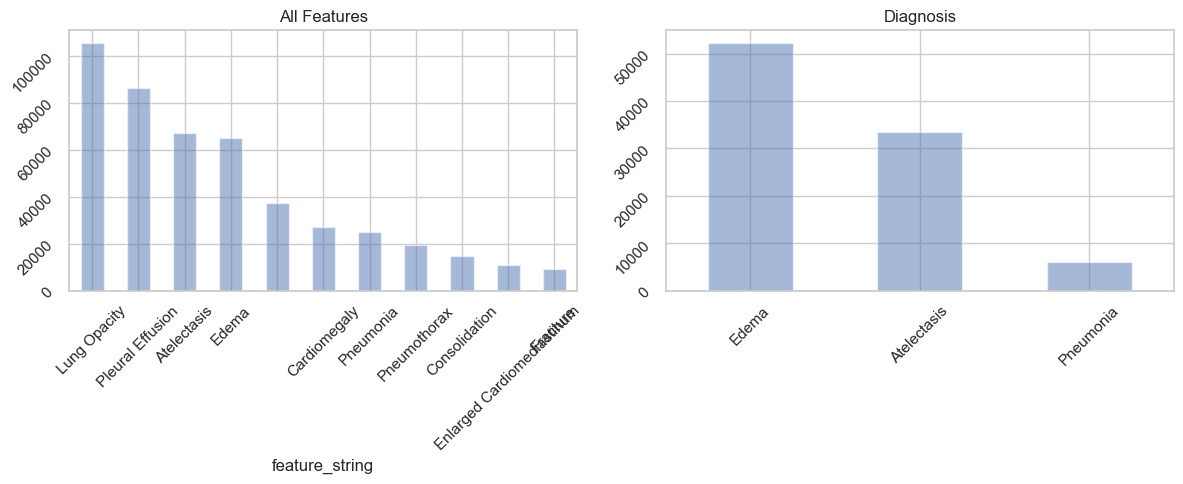

In [79]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Первая диаграмма для всех показателей
labels = df['feature_string'].explode()
labels_count = labels.value_counts()
labels_count.plot(kind='bar', alpha=0.5, ax=axs[0])
axs[0].set_title('All Features')
axs[0].tick_params(rotation=45)

# Вторая диаграмма для диагнозов
diagnosis_labels = [item for sublist in df['diagnosis'] for item in sublist]
diagnosis_labels_count = pd.Series(diagnosis_labels).value_counts()
diagnosis_labels_count.plot(kind='bar', alpha=0.5, ax=axs[1])
axs[1].set_title('Diagnosis')
axs[1].tick_params(rotation=45)

plt.tight_layout()
plt.show()

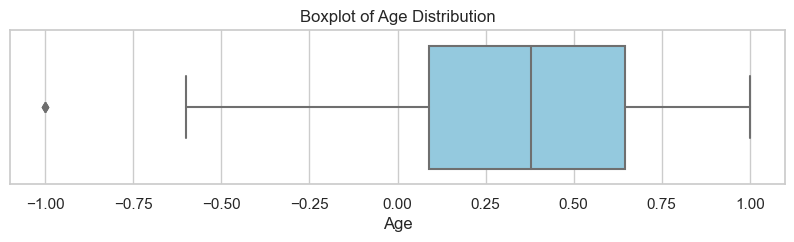

In [80]:
# распределение возраста
sns.set(style="whitegrid")

plt.figure(figsize=(10, 2))
sns.boxplot(x='Age', data=df, color='skyblue')
plt.title('Boxplot of Age Distribution')
plt.show()

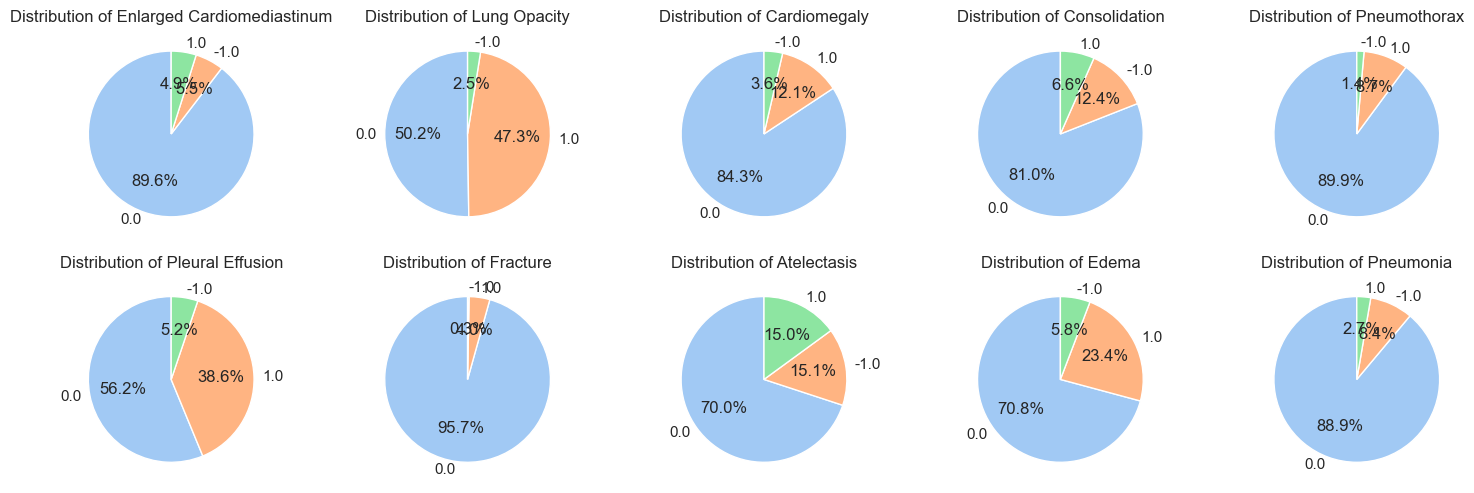

In [81]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features + diagnosis_features, 1):
    plt.subplot(4, (len(features) + len(diagnosis_features) + 1)//2, i)
    df[feature].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
    plt.title(f'Distribution of {feature}')
    plt.ylabel('')

plt.tight_layout()
plt.show()

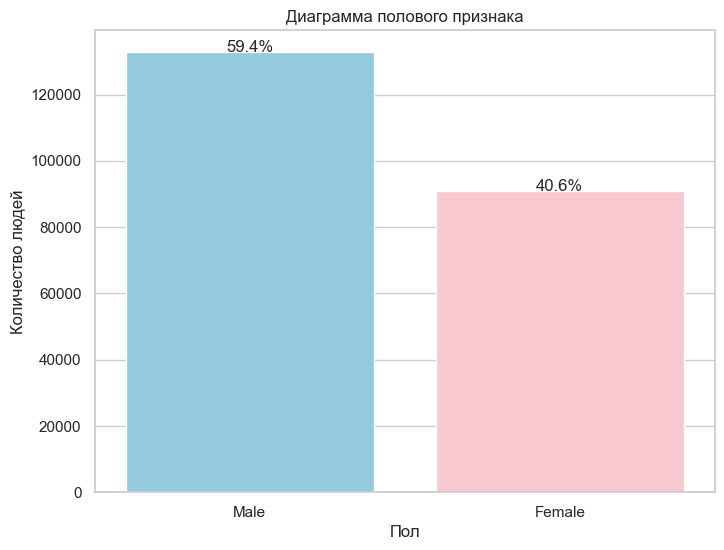

In [82]:
pd.options.mode.chained_assignment = None

# Создаем DataFrame для полового признака
sex_df = df[['Sex_Male', 'Sex_Female']]
sex_df['Sex'] = sex_df.apply(lambda row: 'Male' if row['Sex_Male'] == 1 else 'Female', axis=1)

# Считаем количество людей каждого пола
count_by_sex = sex_df['Sex'].value_counts()

# Настройка палитры Seaborn
colors = {'Male': 'skyblue', 'Female': 'pink'}

# Построение диаграммы с заданными цветами
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x=count_by_sex.index, y=count_by_sex.values, palette=colors.values())

# Добавляем проценты над столбцами
total = len(sex_df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1, f'{height/total:.1%}', ha="center")

# Добавляем подписи и заголовок
plt.xlabel("Пол")
plt.ylabel("Количество людей")
plt.title("Диаграмма полового признака")

# Отображаем график
plt.show()

In [83]:
image_paths = df['Path']

# Список для хранения размеров изображений
image_sizes = []

# Получение размеров каждого изображения
for path in image_paths:
    try:
        with Image.open(path) as img:
            width, height = img.size
            image_sizes.append((width, height))
    except Exception as e:
        print(f"Ошибка при обработке изображения {path}: {e}")

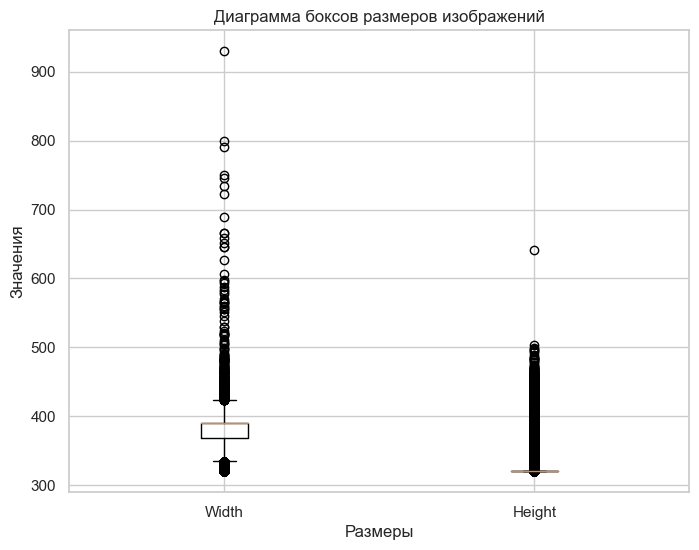

In [84]:
widths, heights = zip(*image_sizes)

plt.figure(figsize=(8, 6))
plt.boxplot([widths, heights], labels=['Width', 'Height'])
plt.title('Диаграмма боксов размеров изображений')
plt.xlabel('Размеры')
plt.ylabel('Значения')
plt.show()

### Возможные кейсы использования полученных мультимодальных данных

#### 1. В теории можно построить модель для **прогнозирования наличия или отсутствия размеченных заболеваний** (Edema, Atelectasis, Pneumonia) на основе изображений и других признаков (ее диагнозы будут носить строго рекомендательный характер, а итоговый диагноз будет все равно ставить врач). Это может помочь в диагностике, раннем обнаружении болезней и оптимизации работы медицинского персонала.

Для задачи прогнозирования наличия или отсутствия размеченных заболеваний можно использовать следующие модели:

- ResNet (Residual Networks): глубокая сверточная нейронная сеть, которая эффективно обрабатывает изображения. Ее архитектура включает блоки с остаточным соединением, что облегчает обучение глубоких моделей.
<p>
    
- Xception: сверточная нейронная сеть, вариация архитектуры Inception (использует блоки с разными размерами ядер, что позволяет эффективно извлекать признаки). Она обладает высокой точностью при обработке изображений.
<p>
    
- Ensemble Models: Сочетание нескольких моделей в ансамбль (например, комбинация ResNet и Xception) может улучшить обобщающую способность и точность предсказаний.
<p>
    

#### 2. Также можно создать модель для **персонализированного прогнозирования риска для каждого пациента**, учитывая все модальности.

Можно рассмотреть следующие подходы и модели:

- Интеграция модальностей: совмещение информации из различных модальностей (изображения, описания, числовые признаки) с использованием подходов, таких как multimodal fusion или late fusion (Concatenation, Element-wise Sum, или Element-wise Multiplication).
<p>
    
- Глубокие модели с многомодальным входом: создание глубоких нейронных сетей с несколькими входами для каждой модальности и общим выходом для предсказания риска.
<p>
    
- Многозадачное обучение: обучение модели на нескольких задачах сразу, таких как классификация изображений и регрессия для прогнозирования риска.
<p>
    
- Интерпретируемость: использование моделей, обеспечивающих интерпретируемость результатов, чтобы врачи могли понять, какие признаки влияют на прогноз риска для каждого пациента (применение LIME (Local Interpretable Model-agnostic Explanations) или SHAP (SHapley Additive exPlanations), чтобы врачи могли понять влияние конкретных признаков на прогноз).